In [1]:
!pip install finance-datareader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from PIL import Image
import random

DAY_NUM = 32 # DAY_NUM거래일만큼의 차트 비교

In [ ]:
def convert_image(data, num_images, day_num, name, code, save = False):

    if len(data) < day_num:
        print("종목 데이터 부족")
        return []

    if num_images > len(data) - day_num + 1:
        num_images = len(data) - day_num + 1


    return_datas = []
    image_idx = 1
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]
        # 이미지 크기 설정
        width, height = day_num * 3, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        open_prices_norm = (open_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))


        # 96x96 이미지 생성
        img = np.ones((height, width, 3), dtype=np.uint8) * 255

        fail_generate = False
        for day in range(day_num):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(open_prices_norm[day] * (height - 1))

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0]  # 상승: 빨강
                    tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0]  # 상승: 빨강
                        tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 0 and img[height - 1 - y, x][2] != 0:
                        img[height - 1 - y, x] = tail_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += 1
            continue

        if save :
            # 이미지 저장
            nimg = Image.fromarray(img, 'RGB')
            nimg.save(f'stock_data_image_{image_idx}.png')


        return_datas.append((img, name, code, stock_data.index[-1]))

        image_idx += 1

    return return_datas

In [ ]:
class StockData:
    def __init__(self, open_prices, close_prices, high_prices, low_prices, max_volume_idx, max_hi_lo_diff_idx, name, code, date):
        self.open_prices = open_prices
        self.close_prices = close_prices
        self.high_prices = high_prices
        self.low_prices = low_prices
        self.max_volume_idx = max_volume_idx
        self.max_hi_lo_diff_idx = max_hi_lo_diff_idx
        self.name = name
        self.code = code
        self.date = date

In [ ]:
RIGHT_QUARTILE = 8 # 맨 마지막 종가를 몇분위로 나눌건지
LEFT_QUARTILE = 8

def convert_norm(data, num_images, day_num, name, code, save=False):
    global structured_stock_data

    if len(data) < day_num:
        print("종목 데이터 부족")
        if save:
            return 0
        else:
            return [[-1, -1, -1, -1, -1, -1]]

    if num_images > len(data) - day_num + 1:
        num_images = len(data) - day_num + 1

    return_data = []
    image_idx = 1
    cnt = 0
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]

        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        volume_data = stock_data['Volume'].values

        if np.count_nonzero(volume_data) < 16: # 거래정지인 날이 16일 이상이면
            image_idx += 1
            continue

        highest_prices = high_prices.max()
        lowest_prices = low_prices.min()
        hi_lo_diff = highest_prices - lowest_prices

        open_prices_norm = (open_prices - lowest_prices) / (hi_lo_diff)
        close_prices_norm = (close_prices - lowest_prices) / (hi_lo_diff)
        high_prices_norm = (high_prices - lowest_prices) / (hi_lo_diff)
        low_prices_norm = (low_prices - lowest_prices) / (hi_lo_diff)
        high_low_diff = high_prices_norm - low_prices_norm

        max_idx = np.argmax(high_prices_norm)
        min_idx = np.argmin(low_prices_norm)
        max_hi_lo_diff_idx = np.argmax(high_low_diff)
        first_close_idx = min(np.digitize(close_prices_norm[0], np.linspace(0, 1, LEFT_QUARTILE + 1)) - 1, LEFT_QUARTILE - 1)
        last_close_idx = min(np.digitize(close_prices_norm[-1], np.linspace(0, 1, RIGHT_QUARTILE + 1)) - 1, RIGHT_QUARTILE - 1)
        max_volume_idx = np.argmax(volume_data)

        # image_idx += random.choice(range(1,4))
        image_idx += 1
        cnt += 1

        if save:
            structured_stock_data[max_idx][last_close_idx][min_idx][first_close_idx][max_hi_lo_diff_idx].append(StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, max_volume_idx, max_hi_lo_diff_idx, name, code, str(stock_data.index[-1])[:10]))
        else:
            return_data.append([max_idx, last_close_idx, min_idx, first_close_idx, max_hi_lo_diff_idx, StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, max_volume_idx, max_hi_lo_diff_idx, name, code, str(stock_data.index[-1])[:10])])

    if save:
        return cnt
    else:
        if not return_data:
            return [[-1, -1, -1, -1, -1, -1]]
        else:
            return return_data

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/codes.csv', usecols=[0, 1], dtype={0: str})
# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['095570', 'AJ네트웍스'], ['006840', 'AK홀딩스'], ['054620', 'APS'], ['265520', 'AP시스템'], ['211270', 'AP위성'], ['027410', 'BGF'], ['282330', 'BGF리테일'], ['126600', 'BGF에코머티리얼즈'], ['138930', 'BNK금융지주'], ['001460', 'BYC'], ['001465', 'BYC우'], ['013720', 'CBI'], ['083790', 'CG인바이츠'], ['001040', 'CJ'], ['079160', 'CJ CGV'], ['035760', 'CJ ENM'], ['311690', 'CJ 바이오사이언스'], ['00104K', 'CJ4우(전환)'], ['000120', 'CJ대한통운'], ['011150', 'CJ씨푸드'], ['011155', 'CJ씨푸드1우'], ['001045', 'CJ우'], ['097950', 'CJ제일제당'], ['097955', 'CJ제일제당 우'], ['051500', 'CJ프레시웨이'], ['058820', 'CMG제약'], ['023460', 'CNH'], ['056730', 'CNT85'], ['000480', 'CR홀딩스'], ['065770', 'CS'], ['083660', 'CSA 코스믹'], ['000590', 'CS홀딩스'], ['012030', 'DB'], ['404950', 'DB금융스팩10호'], ['456440', 'DB금융스팩11호'], ['367360', 'DB금융스팩9호'], ['016610', 'DB금융투자'], ['005830', 'DB손해보험'], ['000990', 'DB하이텍'], ['139130', 'DGB금융지주'], ['060900', 'DGP'], ['025440', 'DH오토웨어'], ['001530', 'DI동일'], ['000210', 'DL'], ['001880', 'DL건설'], ['000215', 'DL우'], ['375500', 'DL이앤씨'

In [ ]:
import pickle

# with open("drive/MyDrive/Colab Notebooks/stock_data_20130801-20230915.pkl", "wb") as f:
    # pickle.dump(stock_data, f)

with open("drive/MyDrive/Colab Notebooks/stock_data_20130801-20230915.pkl", "rb") as f:
    stock_data = pickle.load(f)

In [ ]:
none_stock_data = fdr.DataReader('005930', '1900-01-01', '1900-01-01')

def get_stock_data_start_end(code, start_date, end_date='2023-09-15'):
    global stock_data, none_stock_data

    if start_date not in stock_data[code].index:
        print(f"{data} 날짜가 존재하지 않음")
        return none_stock_data

    return stock_data[code].loc[start_date : end_date]

def get_stock_data_pre_fol(code, date, preceeding = 0, following = 0):
    global stock_data, none_stock_data

    if date not in stock_data[code].index:
        print(f"{data} 날짜가 존재하지 않음")
        return none_stock_data

    index_location = stock_data[code].index.get_loc(date)
    if index_location - preceeding < 0:
        print(f'{code}에 {date}의 앞쪽{preceeding}개 데이터 부족')
        return none_stock_data
    if index_location + following > len(stock_data[code]):
        print(f'{code}에 {date}의 뒤쪽{following}개뒤쪽 데이터 부족')
        return none_stock_data


    start_location = index_location - preceeding
    end_location = min(len(stock_data[code]), index_location + following + 1)
    return stock_data[code].iloc[start_location : end_location]

In [ ]:
# stock_data = {code : 0 for code, name in stock_codes}

# cnt_sum = 0
# for i, ticker in enumerate(stock_codes):
#     code, name = ticker[0], ticker[1]
#     print(f"{i+1}번째 종목 {name} 추출중...   ")
#     stock_data[code] = fdr.DataReader(code, '2013-08-01', '2023-09-15')
#     cnt_sum += len(stock_data[code])
#     print(f"{len(stock_data[code])}개 추출 / 총{cnt_sum}개")

In [ ]:
# open_close_data = [[[[[[] for _ in range(DAY_NUM)] for _ in range(LEFT_QUARTILE)] for _ in range(DAY_NUM)] for _ in range(RIGHT_QUARTILE)] for _ in range(DAY_NUM)]
# def process():
#     global open_close_data
#     cnt_sum = 0
#     for i, ticker in enumerate(stock_codes):
#         code, name = ticker[0], ticker[1]
#         print(f"{i+1}번째 종목 {name} 추출중...   ")

#         try:
#             data = stock_data[code]  # 각 종목의 데이터 가져오기
#             cnt = convert_norm(get_stock_data_se(code, '2013-08-01', '2018-12-31'), 3000, DAY_NUM, name, code, save=True)
#             cnt_sum += cnt
#             print(f"{cnt}개 추출 / 총{cnt_sum}개")

#         except IndexError:
#             print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
#             continue

# process()

In [ ]:
# data_year = [[[[[[] for _ in range(DAY_NUM)] for _ in range(LEFT_QUARTILE)] for _ in range(DAY_NUM)] for _ in range(RIGHT_QUARTILE)] for _ in range(DAY_NUM)]

# cnt = 0
# for u in range(DAY_NUM):
#     for r in range(RIGHT_QUARTILE):
#         for d in range(DAY_NUM):
#             for l in range(LEFT_QUARTILE):
#                 for dif in range(DAY_NUM):
#                     for data in open_close_data[u][r][d][l][dif]:
#                         if data.date[3] == '4':
#                             data_year[u][r][d][l][dif].append(data)
#                             cnt += 1
# print(cnt)

404730


In [ ]:
# import pickle

# with open("drive/MyDrive/Colab Notebooks/structured_stock_data_2014.pkl", "wb") as f:
    # pickle.dump(data_year, f)

# with open("drive/MyDrive/Colab Notebooks/2023_0915.pkl", "rb") as f:
    # open_close_data = pickle.load(f)

In [ ]:
 # Create a weight array that gives more weight to later elements
def rmse(predictions, targets, max_volume_idx):
    weights = np.linspace(1, 2, DAY_NUM) # 최근 날짜일수록 가중치 크게

    weights[max_volume_idx] *= 16 # 거래량이 제일 많은 날은 가중치 더 크게
    if max_volume_idx + 1 < DAY_NUM:
        weights[max_volume_idx+1] *= 4
    if max_volume_idx - 1 >= 0:
        weights[max_volume_idx-1] *= 4

    # Calculate the squared errors
    squared_errors = ((predictions - targets) ** 2)

    # Apply the weights to the squared errors
    weighted_squared_errors = weights * squared_errors

    # Calculate the mean and square root
    return np.sqrt(weighted_squared_errors.mean())

In [ ]:
import numpy as np
import heapq

similar = {code : [] for code, name in stock_codes}  # 유사한 이미지들을 저장할 리스트

code_cnt = 0
for year in ['20230915', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014']:

    with open("drive/MyDrive/Colab Notebooks/structured_stock_data_" + year + ".pkl", "rb") as f:
        structured_stock_data = pickle.load(f)

    cnt = 0
    for code, name in stock_codes:
        code_cnt += 1
        # print(f'{code_cnt}번째 종목 {code} / {name} ', end='')
        # code = '005930'
        up, right, down, left, m, latest_data = convert_norm(get_stock_data_pre_fol(code, '2023-09-15', preceeding=31), 1, DAY_NUM, name, code)[0]


        if up == -1:
            print(f"{name}에 기준날짜 정보가 없음(거래정지)")
            continue

        high_low_diff = np.argsort(latest_data.high_prices - latest_data.low_prices)[::-1][:3]

        for u in range(max(up - 1, 0), min(up + 2, DAY_NUM)):
            for r in range(max(right - 1, 0), min(right + 2, RIGHT_QUARTILE)):
                for d in range(max(down - 2, 0), min(down + 3, DAY_NUM)):
                    for l in range(max(left - 2, 0), min(left + 3, LEFT_QUARTILE)):
                        for hl in high_low_diff:
                            for data in structured_stock_data[u][r][d][l][hl]:
                                dif = rmse(latest_data.open_prices, data.open_prices, latest_data.max_volume_idx) + rmse(latest_data.close_prices, data.close_prices, latest_data.max_volume_idx) + rmse(latest_data.high_prices, data.high_prices, latest_data.max_volume_idx) + rmse(latest_data.low_prices, data.low_prices, latest_data.max_volume_idx)
                                # (유사도 음수값, 데이터) 형태로 힙에 추가합니다.
                                heapq.heappush(similar[code], [-dif, data.code, data.date])

                                # similar 리스트의 크기가 100을 초과하면 가장 작은 원소(즉, 유사도가 가장 낮은 원소)를 제거합니다.
                                if len(similar[code]) > 100:
                                    heapq.heappop(similar[code])

                                cnt += 1
    print(f"{year}에서 {cnt} 개 추출")


for code, name in stock_codes:
    similar[code].sort(reverse=True)

DB금융스팩10호에 기준날짜 정보가 없음(거래정지)
IBKS제19호스팩에 기준날짜 정보가 없음(거래정지)
IHQ에 기준날짜 정보가 없음(거래정지)
ITX-AI에 기준날짜 정보가 없음(거래정지)
458320에 2023-09-15의 앞쪽31개 데이터 부족
종목 데이터 부족
KB제26호스팩에 기준날짜 정보가 없음(거래정지)
KH 건설에 기준날짜 정보가 없음(거래정지)
KH 전자에 기준날짜 정보가 없음(거래정지)
KH 필룩스에 기준날짜 정보가 없음(거래정지)
MIT에 기준날짜 정보가 없음(거래정지)
465770에 2023-09-15의 앞쪽31개 데이터 부족
종목 데이터 부족
STX그린로지스에 기준날짜 정보가 없음(거래정지)
광림에 기준날짜 정보가 없음(거래정지)
국일제지에 기준날짜 정보가 없음(거래정지)
092790에 2023-09-15의 앞쪽31개 데이터 부족
종목 데이터 부족
넥스틸에 기준날짜 정보가 없음(거래정지)
노블엠앤비에 기준날짜 정보가 없음(거래정지)
녹원씨엔아이에 기준날짜 정보가 없음(거래정지)
뉴지랩파마에 기준날짜 정보가 없음(거래정지)
대신밸런스제14호스팩에 기준날짜 정보가 없음(거래정지)
457390에 2023-09-15의 앞쪽31개 데이터 부족
종목 데이터 부족
대신밸런스제15호스팩에 기준날짜 정보가 없음(거래정지)
457630에 2023-09-15의 앞쪽31개 데이터 부족
종목 데이터 부족
대신밸런스제16호스팩에 기준날짜 정보가 없음(거래정지)
대양제지에 기준날짜 정보가 없음(거래정지)
대유에 기준날짜 정보가 없음(거래정지)
더라미에 기준날짜 정보가 없음(거래정지)
디에스앤엘에 기준날짜 정보가 없음(거래정지)
명성티엔에스에 기준날짜 정보가 없음(거래정지)
백광산업에 기준날짜 정보가 없음(거래정지)
버킷스튜디오에 기준날짜 정보가 없음(거래정지)
베스파에 기준날짜 정보가 없음(거래정지)
부산주공에 기준날짜 정보가 없음(거래정지)
비덴트에 기준날짜 정보가 없음(거래정지)
비디아이에 기준날짜 정보가 없음(거래정지)
비케이탑스에 기준날짜 정보가 없음(거

In [ ]:
similar['005930']

[[-0.0, '005930', '2023-09-15'],
 [-0.5711849930561388, '000430', '2015-09-21'],
 [-0.5952078634993302, '078520', '2022-04-15'],
 [-0.6318549324704623, '054540', '2022-07-21'],
 [-0.6513778462784383, '126700', '2014-04-16'],
 [-0.6662575010370584, '024900', '2014-03-11'],
 [-0.6697793692571925, '265560', '2020-02-28'],
 [-0.6775899915827696, '005670', '2015-03-05'],
 [-0.678773790893562, '033640', '2019-09-03'],
 [-0.682117139406215, '257720', '2022-11-08'],
 [-0.6932109744697716, '073490', '2015-06-25'],
 [-0.6954090103974881, '072470', '2022-07-21'],
 [-0.697520294454751, '098120', '2014-08-28'],
 [-0.7037087068937302, '264660', '2019-09-03'],
 [-0.70986217912057, '287410', '2021-03-26'],
 [-0.7148472162580564, '045970', '2023-09-15'],
 [-0.7166368826062735, '009835', '2022-08-11'],
 [-0.7212497871320441, '203690', '2018-08-22'],
 [-0.7263323139853065, '020760', '2023-04-12'],
 [-0.7348812442617421, '011810', '2019-01-29'],
 [-0.7437734321500142, '007340', '2022-11-23'],
 [-0.7442835

In [ ]:
import pickle

with open("drive/MyDrive/Colab Notebooks/similar_stock_data_20230915.pkl", "wb") as f:
    pickle.dump(similar, f)

# with open("drive/MyDrive/Colab Notebooks/similar_stock_data_20230915.pkl", "rb") as f:
    # similar = pickle.load(f)

In [ ]:
from datetime import datetime, timedelta

similar_images = {code : [] for code, name in stock_codes}
for code, name in stock_codes:
    # code = '005930'
    for dif, data in similar[code]:

        stock = get_stock_data_pre_fol(data.code, data.date, preceeding=31)  # 각 종목의 데이터 가져오기
        image = convert_image(stock, 1, DAY_NUM, data.name, data.code)

        if len(image) == 0:
            continue

        data.image = image[0][0]
        similar_images[code].append((dif, data))
    print(name)

AJ네트웍스
AK홀딩스
APS
AP시스템
AP위성
BGF
BGF리테일
BGF에코머티리얼즈
BNK금융지주
BYC
BYC우
CBI
CG인바이츠
CJ
CJ CGV
CJ ENM
CJ 바이오사이언스
CJ4우(전환)
CJ대한통운
CJ씨푸드
CJ씨푸드1우
CJ우
CJ제일제당
CJ제일제당 우
CJ프레시웨이
CMG제약
CNH
CNT85
CR홀딩스
CS
CSA 코스믹
CS홀딩스
DB
DB금융스팩10호
DB금융스팩11호
DB금융스팩9호
DB금융투자
DB손해보험
DB하이텍
DGB금융지주
DGP
DH오토웨어
DI동일
DL
DL건설
DL우
DL이앤씨
DL이앤씨2우(전환)
DL이앤씨우
DMS
DN오토모티브
DRB동일
DSC인베스트먼트
DSEN
DSR
DSR제강
DXVX
E1
EDGC
EG
ESR켄달스퀘어리츠
ES큐브
F&F
F&F홀딩스
FSN
GH신소재
GKL
GRT
GS
GST
GS건설
GS글로벌
GS리테일
GS우
HB솔루션
HB테크놀러지
HDC
HDC랩스
HDC현대EP
HDC현대산업개발
HD한국조선해양
HD현대
HD현대건설기계
HD현대에너지솔루션
HD현대인프라코어
HD현대일렉트릭
HD현대중공업
HJ중공업
HK이노엔
HL D&I
HLB
HLB글로벌
HLB바이오스텝
HLB생명과학
HLB이노베이션
HLB제약
HLB테라퓨틱스
HLB파나진
HL만도
HL홀딩스
HMM
HPSP
HRS
HSD엔진
HS애드
IBKS제17호스팩
IBKS제19호스팩
IBKS제20호스팩
IBKS제21호스팩
IBKS제22호스팩
IHQ
ISC
ITX-AI
JB금융지주
JTC
JW생명과학
JW신약
JW중외제약
JW중외제약2우B
JW중외제약우
JW홀딩스
JYP Ent.
KBG
KBI메탈
KB금융
KB스타리츠
KB오토시스
KB제25호스팩
KB제26호스팩
KCC
KCC건설
KCC글라스
KCI
KCTC
KC그린홀딩스
KC코트렐
KD
KEC
KG ETS
KG모빌리언스
KG모빌리티
KG스틸
KG이니시스
KG케미칼
KH 건설
KH 전자
KH 필룩스
KH바텍
KIB플러그에너지
KISCO홀딩스
KNN
KPX케미칼
KPX홀딩스
KR모터스
KS

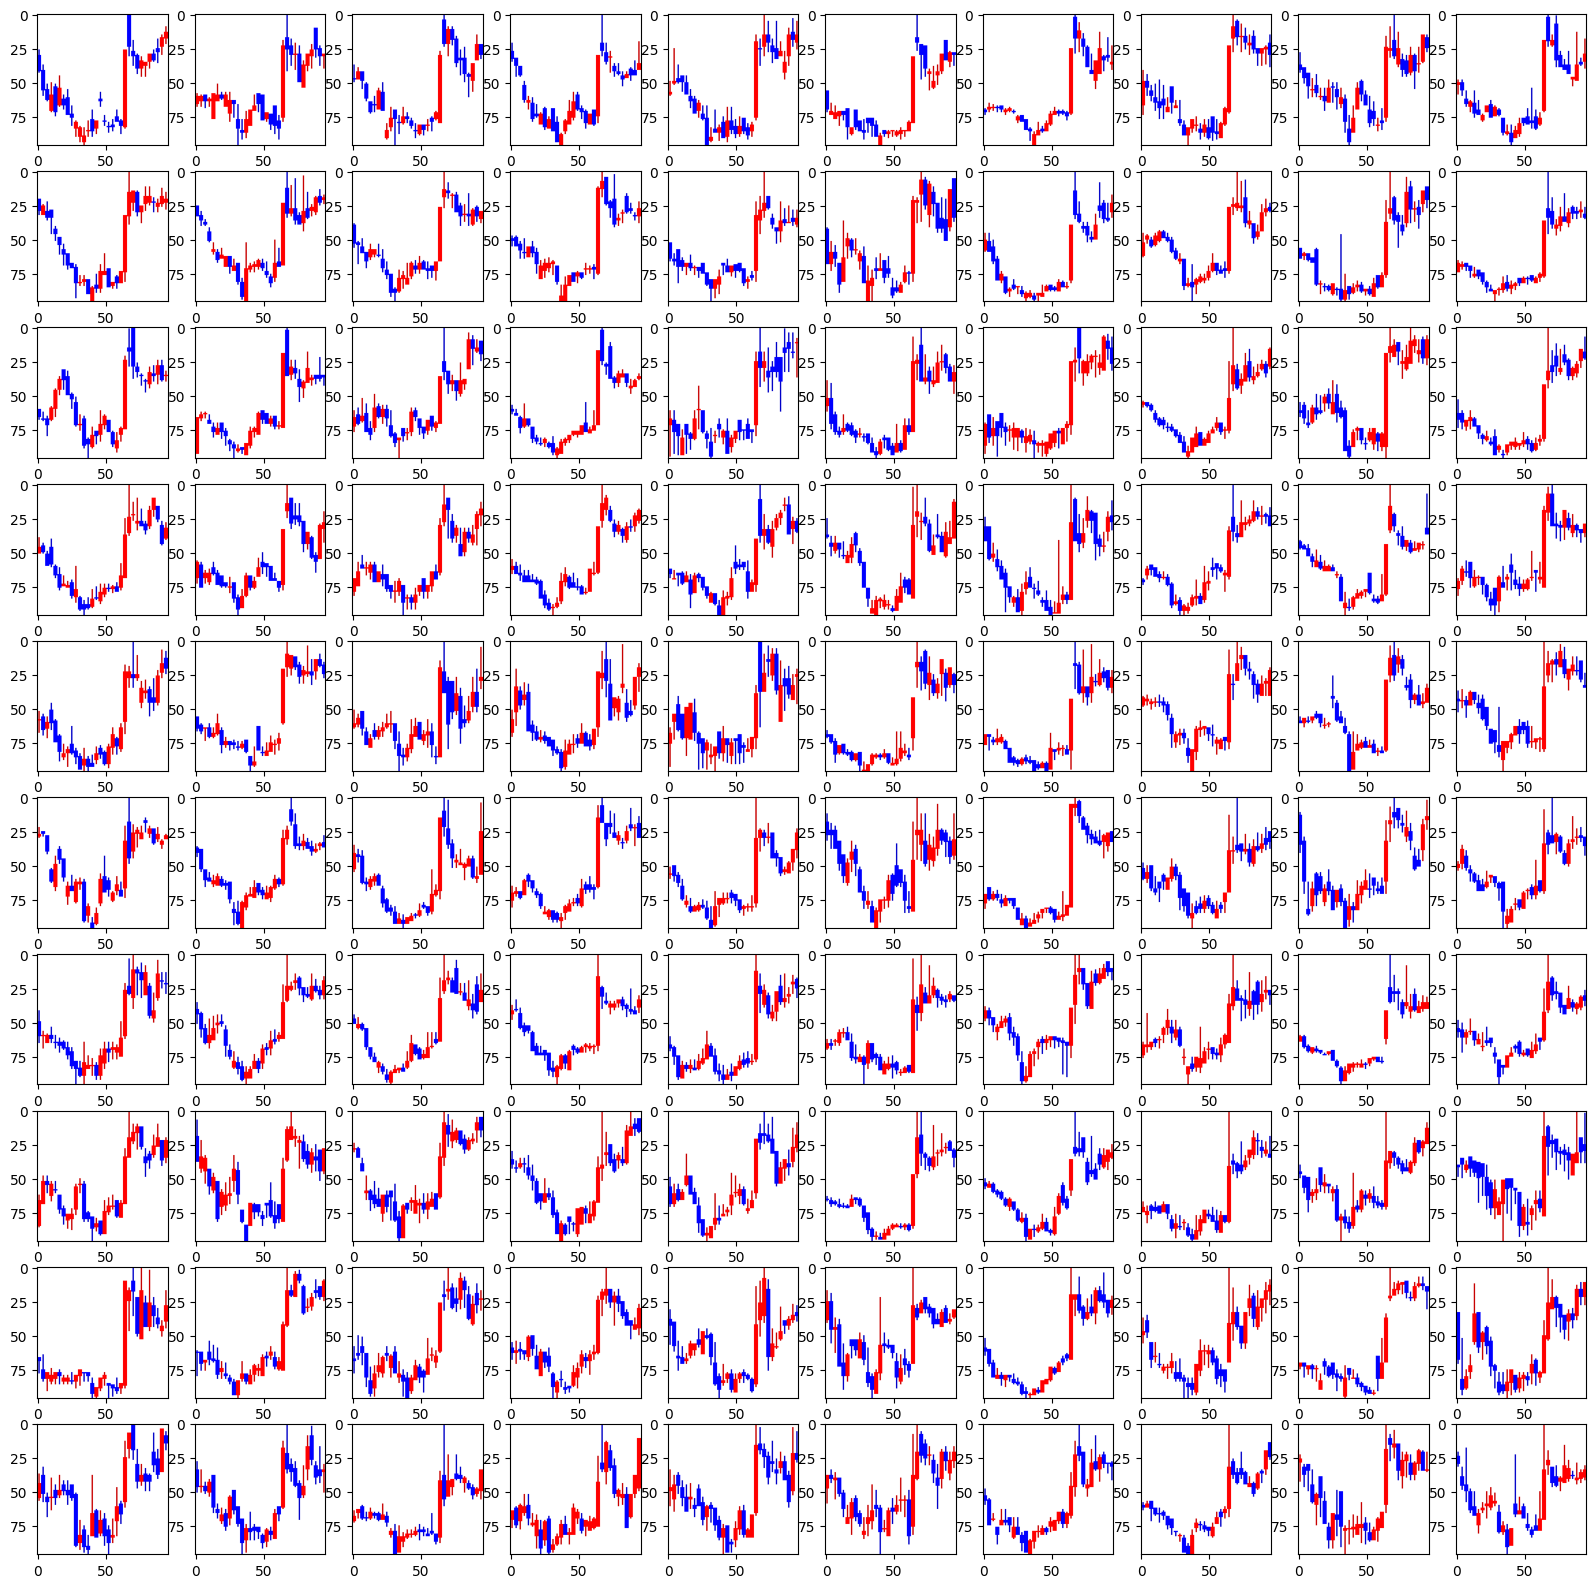

3.072601351204181e-06 삼성전자 2023-09-15
-0.5711811425148897 대원강업 2015-09-21
-0.5951983797277742 에이블씨엔씨 2022-04-15
-0.6318507905449285 삼영엠텍 2022-07-21
-0.6513685892745681 하이비젼시스템 2014-04-16
-0.6662539689098191 덕양산업 2014-03-11
-0.669771875621555 영화테크 2020-02-28
-0.6775815076739399 푸드웰 2015-03-05
-0.6787678913595443 네패스 2019-09-03
-0.6821134142369539 실리콘투 2022-11-08
-0.6932034954901544 이노와이어리스 2015-06-25
-0.6954044993409643 우리산업홀딩스 2022-07-21
-0.6975114709160598 마이크로컨텍솔 2014-08-28
-0.7037017986876651 씨앤지하이테크 2019-09-03
-0.7098550397784206 제이시스메디칼 2021-03-26
-0.7148459073791932 코아시아 2023-09-15
-0.7166285757825718 한화솔루션우 2022-08-11
-0.7212482814792887 스피어파워 2018-08-22
-0.7263247953477404 일진디스플 2023-04-12
-0.7348762399866015 STX 2019-01-29


In [ ]:
import matplotlib.pyplot as plt
import math

code = '005930'
latest_image = convert_image(get_stock_data(code, '2023-09-15', preceeding=31), 1, DAY_NUM, '삼성전자', '005930')[0][0]

# 한 행에 표시될 서브플롯 수 (예: 4개)
cols = 10

# 필요한 행 수 계산
rows = math.ceil(50 / cols)

# 새로운 figure 생성
plt.figure(figsize=(20, rows * 2))

# 모든 유사한 이미지 출력
i = 0
for dif, data in similar_images[code][:50]:
    plt.subplot(rows, cols, i+1)
    plt.imshow(data.image)
    # plt.axis('off')  # 축 제거
    i += 1

plt.show()
for dif, data in similar_images[code][:20]:
    print(dif, data.name, data.date)